# EVOLUTIONARY CITY MODEL
## An Agent Based Model
*Put this notebook in the same folder where the virtualenv is created to avoid dependency conflicts.*

### Model Description 

* The model uses a payoff function of the form $$Ern + \frac{k}{r} - cn^2$$, 
    - $E$ is Shannon Entropy within a cell. We use the following discretized form with two types of agents ($L$ or $H$) depending on abilities. $$E = -\frac{t}{n}\log_e\left(\frac{t}{n}\right) - \frac{n-t}{n}\log_e\left(\frac{n-t}{n}\right)$$ 
    - $n$ is the number of agents in the cell
    - $t$ is the type count of agents in a cell depending on ability. Each agent is labelled type $H$(high skilled) for               $r\geqslant0.6$ or $L$ (low skilled) otherwise. 
    - $r$ is the ability of an agent, drawn from a uniform distribution (0,1). 
    - $k$ and $c$ are user settable coefficients and model parameters. 
    
    
* Agents use bounded rationality. Each agent is initialized with attribute **radius** which defines the maximum number of cells it considers while making a move. This is drawn from a beta distribution. 


* The model takes the total number of agents $N$, the positive coefficient $k$ and negative coefficient $c$ as inputs. The model also takes agent activation schedule as input to test two schedules. Pass **activation = 0** for Random Activation and **activation = 1** for Simultaneous Activation.


* The implementation defines the agents under class **habitant** and city model under class **city_model**. 

* **shannon_E** is a global function that returns the entropy of a cell. 


* There are 4 model level data collectors-
  - **city_sizes** -  returns an array corresponding to model grid containing the number of agents in each cell.   
  - **city_ranks** - returns a list of tuples. Each tuple contains the cell coordinates and its rank.
  - **model_entropy** - returns a list of lists. Each sublist contains the cell coordinates and its entropy.
  - **model_utility** - returns a utility of the entire model which is simply sum of individual agent utilities.  


* At each model step, the agents calculate the payoff before moving into one of their neighboring cells. If the payoff is higher than the agent's current cell, it makes a move otherwise stays put in his current cell.


* **BatchRunner** is used to run the model instances multiple times.


* Some more work is needed to integrate the server properly for the model. To change the code and launch the server again specify a different server.port or quit the notebook and launch again from command prompt. This might be a problem specific to my environment setup but might help somebody. 

In [114]:
from mesa import Agent, Model
from mesa.time import RandomActivation, SimultaneousActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import pandas as pd
import random
import numpy as np
import math
import time
import collections
import operator
from IPython.display import clear_output
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import CanvasGrid, ChartModule, TextElement
from mesa.visualization.UserParam import UserSettableParameter
from mesa.batchrunner import BatchRunner
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.ticker as ticker
import scipy.stats as st
from scipy.stats import norm

In [115]:
'''Function to calculate Entropies'''
def shanon_E(type_count, num_agents):
    t = type_count 
    n = num_agents
    if t == n or t == 0 or n == 0:
        return 0  # O entropy if all agents are of same type or no agents in a cell
    else:
        return -(t/n) * math.log(t/n) -((n - t)/n) * math.log((n - t)/n)


'''Model Reporters'''
def city_sizes(model):
    agent_counts = np.zeros((model.grid.width, model.grid.height))
    for cell in model.grid.coord_iter():
        cell_content, x, y = cell
        agent_count = len(cell_content)
        agent_counts[x][y] = agent_count
    return agent_counts

def city_ranks(model):   
    ranklist = []
    for cell in model.grid.coord_iter():
        cell_content, x, y = cell
        ranklist.append(((x,y),len(cell_content)))
        
    ranklist.sort(key=operator.itemgetter(1), reverse=True)
    return ranklist
        
def model_utility(model):
    agent_utility = [agent.utility(agent.pos) for agent in model.schedule.agents]
    return sum(agent_utility)


def model_entropy(model):
    entropy_list = []
    for cell in model.grid.coord_iter():
        type_count = 0
        cell_agents, x, y = cell
        num_agents = len(cell_agents)

        for agent in cell_agents:
            if agent.type == 'L':
                type_count += 1

        entropy_list.append([(x,y), shanon_E(type_count, num_agents)])

    return entropy_list
    
'''Agent Class'''
class habitant(Agent):
    
    def __init__(self, unique_id, model, agent_ability):
        super().__init__(unique_id, model)
        self.r = agent_ability
        self.radius = math.ceil(np.random.beta(1,1) * (self.model.width/2))
        self.type = None
        if 0 <= 10*self.r < 6:
            self.type = 'L'
        elif 6 <= 10*self.r <=10:
            self.type = 'H' 
            
        self.steps = 0
        self.no_moves = 0
        
    def utility(self, coord):
                
        tot_agents = self.model.grid.get_cell_list_contents(coord)
        n = len(tot_agents)
        agent_types = [agent.type for agent in tot_agents]
        S = 0
        if self.type == 'L':
            S = agent_types.count('L')
        else: 
            S = agent_types.count('H')
                
        # check utility for current cell or neighbouring cell        
        if coord != self.pos:
            # +1 term if the agent considers neighbouring cell
            return (shanon_E(S+1,n+1) * self.r * (n + 1)) + (self.model.k / self.r) - (self.model.c * (n + 1)**2)  
        else:
            # utility stays the same if agent stays put in current cell

            return (shanon_E(S,n) * self.r * n) + (self.model.k / self.r) - (self.model.c * n**2)    
        
   
    
    def move(self):
        
        neighbor_cell_pos = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False, radius=self.radius)
        cell_dict = {}     # define a cell dictionary = {keys = (coordinates): values = utiltity}
        max_pos = None
        
        for n in neighbor_cell_pos:     
            cell_dict[n] = self.utility(n)
            
            MaxValue = max(cell_dict.items(), key=lambda x: x[1])    
            # get the coordinates of maximum utility 
            listcoords = []
            # Iterate over all the items in dictionary to find keys with max value
            for coord, util in cell_dict.items():
                if util == MaxValue[1]:
                    listcoords.append(coord)
                    
            max_pos = random.choice(listcoords)  # make a random choice if multiple cells have same utility
            # move only when moving gives a utility benefit
            if self.utility(max_pos) > self.utility(self.pos):
                self.model.grid.move_agent(self, max_pos)
                
            else: self.no_moves += 1
                          
    def step(self):
        # for RandomActivation
        if self.model.act == 0:
            self.move()
        elif self.model.act == 1:
            self.steps += 1
    
    # for SimultaneousActivation
    def advance(self):    
        self.move()
        
'''Model Class'''
class city_model(Model):
    """Note the default model parameters"""
    def __init__(self, height = 20, width = 20, N = 1000, neg_coff = 0.1, pos_coff = 1, activation = 0):
        assert activation in [0,1], 'Activation should be "0 or 1". O for Random , 1 for Simultaneous'
        self.height = height
        self.width = width
        self.num_agents = N
        self.c = neg_coff
        self.k = pos_coff
        self.act = activation
        
        if self.act == 0:
            self.schedule = RandomActivation(self)
        elif self.act == 1:
            self.schedule = SimultaneousActivation(self) 
        
        self.grid = MultiGrid(width, height, True)
        self.running = True
        #Create agents with some ability
        for i in range(self.num_agents):
            agent_ability = np.random.uniform()
            agent = habitant(i, self, agent_ability)
            self.schedule.add(agent)
    
            # Add the agent to random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x,y))
            
        self.datacollector = DataCollector(model_reporters = {"City_sizes": city_sizes, 
                                                              "Entropy": model_entropy,
                                                             "Ranks": city_ranks,
                                                             "Utility": model_utility}) 
      
    def step(self):
        """Advance the model by one step"""
        self.datacollector.collect(self) 
        self.schedule.step()

### Now, run the model and collect data

In [120]:
model = city_model() # default params used
STEPS = 20
for i in range(STEPS): #run model for some steps
    model.step()
    
city_evolution = model.datacollector.get_model_vars_dataframe()

### Visualize city sizes at each step

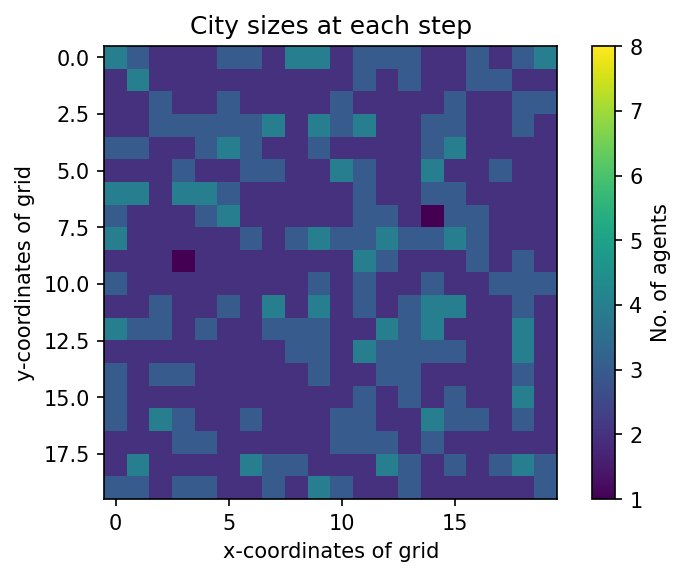

In [205]:
## Plot city sizes over time. Colorbar should have fixed values to make it more clear.
MIN = min(min(min(x.tolist()) for x in city_evolution["City_sizes"]))
MAX = max(max(max(x.tolist()) for x in city_evolution["City_sizes"]))

for i in range(STEPS):
    fig = plt.figure(dpi=150)
    plt.imshow(city_evolution["City_sizes"][i])
    plt.title("City sizes at each step")
    plt.xlabel("x-coordinates of grid")
    plt.ylabel("y-coordinates of grid")
    plt.colorbar(label="No. of agents")
    plt.clim(MIN, MAX)
    plt.show()
    time.sleep(0.2)
    clear_output(wait=True)

### Plot overall model utitlites at each step

<AxesSubplot:title={'center':'Model Utilities at each step'}, xlabel='steps', ylabel='utility'>

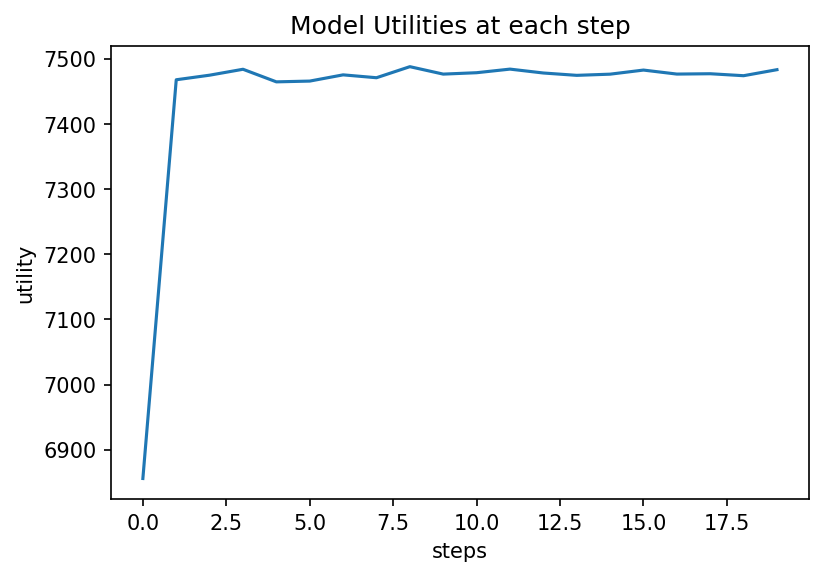

In [122]:
fig = plt.figure(dpi=150)
city_evolution["Utility"].plot(xlabel="steps", ylabel="utility",title="Model Utilities at each step")

### Visualize city rank - size distribution of cities(cells) at each step

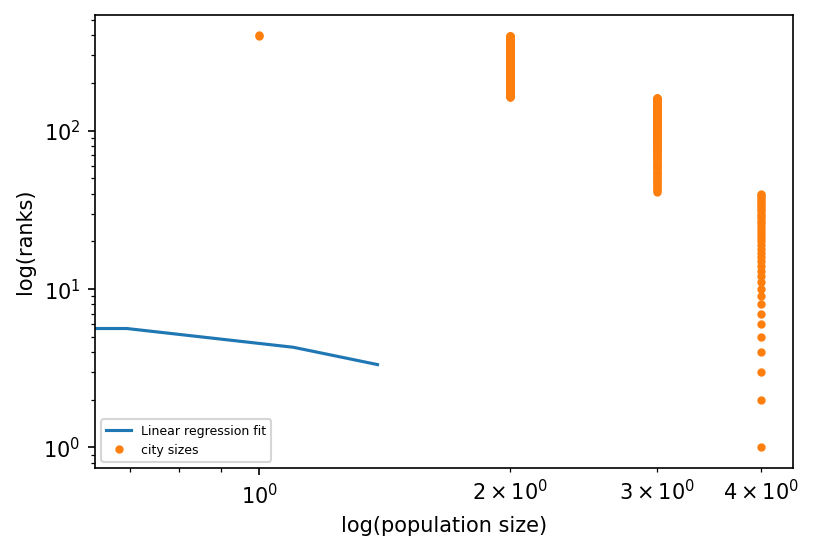

In [162]:
#city_evolution.head()
#city_evolution.iloc[0]["City_sizes"]
  
for i in range(STEPS):
    ranklist = city_evolution.iloc[i]["Ranks"]
    n = len(ranklist)
    ranks = range(1, n+1)                        # y-axis: log(the ranks)
    pops = [pops for (coords, pops) in ranklist] # x-axis: log(the poplution size)
    ## Remove 0's to avoid log(0)
    if 0 in pops:
        idx = pops.index(0)
        pops = pops[:idx]
        ranks = ranks[:idx]
        
    # regression
    m, b = np.polyfit(np.log(np.array(pops)), np.log(np.array(ranks)), 1)
    fig = plt.figure(dpi=150)
    plt.plot(np.log(np.array(pops)), m * np.log(np.array(pops)) + b, label="Linear regression fit")
    plt.loglog(pops, ranks, '.',label='city sizes') 
    plt.xlabel('log(population size)')
    plt.ylabel('log(ranks)')
    plt.legend(loc='lower left',prop={'size': 6})
    plt.show()
    time.sleep(0.5)
    clear_output(wait=True)  

### See entropy distribution of cities at the end of each Model run. 

**Visualise entropy distribution at each step using histograms**

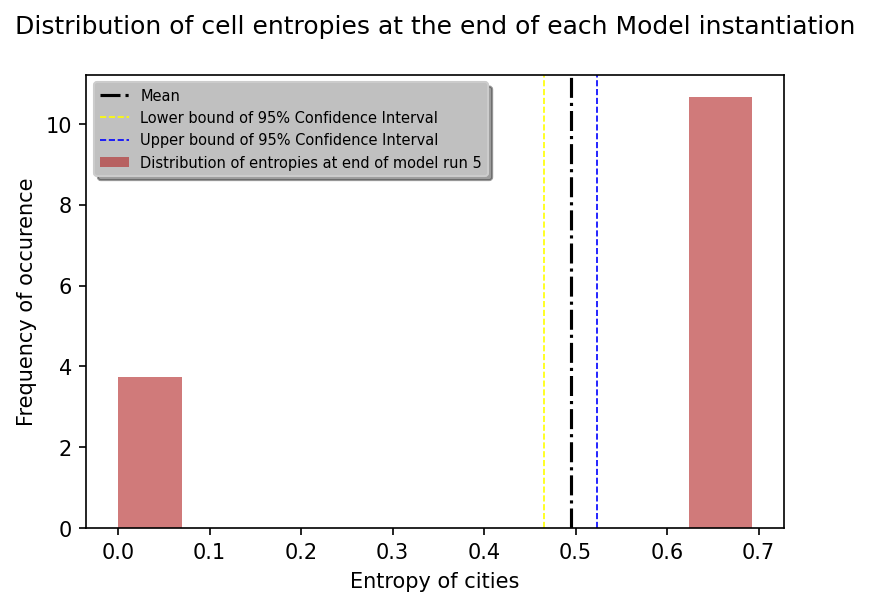

In [46]:
for i in range(5):                       # iterate the model 5 times
    model = city_model()                 # default params used
    for j in range(STEPS):                  # run each model for 20 steps
        model.step()
    city_evolution = model.datacollector.get_model_vars_dataframe()    
    eList = []
    for j in city_evolution.iloc[STEPS-1]["Entropy"]:   # check the entropies at end of model run
        eList.append(j[1])   
    intv95 = st.norm.interval(alpha=0.95, loc=np.mean(eList), scale=st.sem(eList))
    # Plot the histogram.
    fig = plt.figure(dpi=150)
    plt.hist(eList, bins= "auto", density=True,color='firebrick',alpha=0.6, 
             label="Distribution of entropies at end of model run {}".format(i+1))
    plt.axvline(x=np.mean(eList), color='k', linestyle='dashdot', label="Mean")
    plt.axvline(x=intv95[0],color='yellow',linestyle='--',linewidth=0.8,label='Lower bound of 95% Confidence Interval')
    plt.axvline(x=intv95[1],color='blue',linestyle='--',linewidth=0.8,label='Upper bound of 95% Confidence Interval')
    plt.xlabel('Entropy of cities')
    plt.ylabel('Frequency of occurence')
    plt.title("Distribution of cell entropies at the end of each Model iteration",pad=20)
    plt.legend(loc='best', shadow=True, prop={'size': 7}, facecolor="silver")
    plt.show()
    time.sleep(0.1)
    clear_output(wait=True)

**Visualise entropy distribution using violin plots**

In [96]:
mod_iters = []
for i in range(5):                       # iterate the model 5 times
    model = city_model()                 # default params used
    for j in range(STEPS):                # run each model for 20 steps
        model.step()
    city_evolution = model.datacollector.get_model_vars_dataframe()    
    eList = []
    for j in city_evolution.iloc[STEPS-1]["Entropy"]:   # check the entropies at end of model iteration
        eList.append(j[1])
    mod_iters.append(eList)

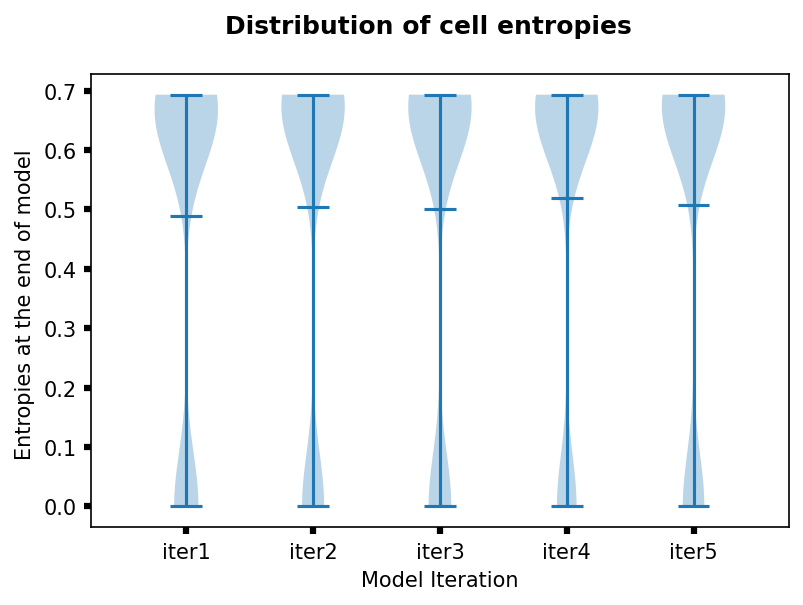

In [98]:
data = mod_iters
fig, ax = plt.subplots(dpi = 150)

ax.violinplot(data,showmeans=True)
ax.get_xaxis().set_tick_params(direction='out')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(np.arange(1, 6))
labels = []
for i in range(5):
    labels.append("iter{}".format(i+1))
ax.set_xticklabels(labels)
ax.set_xlim(0.25, 5.75)
ax.set_xlabel(r'Model Iteration',fontsize=10)
ax.set_ylabel('Entropies at the end of model ',fontsize=10)
fig.suptitle(r'Distribution of cell entropies',fontweight='bold',fontsize=12)
ax.tick_params(labelsize='medium', width=3)
plt.show()

### Server

In [44]:
def city_draw(agent):
    """
    Portrayal Method for canvas
    """
    if agent.type == 'L':  # red for L
        portrayal = {"Shape": "rect","w": 0.2,"h":0.2, "Color": "red","Filled": "false","Layer":0 }
    else:                  # green for H
        portrayal = {"Shape": "circle","r": 0.5, "Color": "green","Filled": "true","Layer":1 }
            
    return portrayal

grid = CanvasGrid(city_draw, 20, 20, 500, 500)
chart = ChartModule([{"Label": "Utility",
                      "Color": "Black"}],
                    data_collector_name='datacollector')
model_params = {
    "height": 20,
    "width": 20,
    "N": UserSettableParameter("slider", "Number of Agents", 1000, 500, 2500, 500),
    "neg_coff": UserSettableParameter("slider", "Negative coefficient(c)", 0.1, 0.05, 0.25, 0.05),
    "pos_coff": UserSettableParameter("slider", "Positive Coefficeint(k)", 1, 0.5, 2, 0.25),
    "activation": UserSettableParameter("slider", "0 for Random, 1 for Simulatneous", 0, 0, 1, 1)}

server = ModularServer(city_model, [grid, chart], "City Model", model_params)
server.launch()

Interface starting at http://127.0.0.1:8521


OSError: [WinError 10048] Only one usage of each socket address (protocol/network address/port) is normally permitted